# <center>Predicting yelp Elite user</center>

## 1. Load user data and dependencies

In [313]:
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pandas.plotting import scatter_matrix
from ast import literal_eval 
from collections import defaultdict
import datetime

import torch
from torch import nn
from torch.utils import data
from d2l import torch as d2l
from torch.autograd import Variable
# analysis
import statsmodels.api as sm
from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, mean_squared_error
from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix
from sklearn.preprocessing import normalize, scale, StandardScaler, Normalizer
from sklearn.pipeline import Pipeline, make_pipeline

from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

%matplotlib inline

In [2]:
users = pd.read_json('yelp_academic_dataset_user.json',lines=True)

In [3]:
users.head()

,yelping_since,votes,review_count,name,user_id,friends,fans,average_stars,type,compliments,elite
0,2004-10,"{'funny': 167, 'useful': 282, 'cool': 246}",108,Russel,18kPq7GPye-YQ3LyKyAZPw,"[rpOyqD_893cqmDAtJLbdog, 4U9kSBLuBDU391x6bxU-Y...",69,4.14,user,"{'profile': 8, 'cute': 15, 'funny': 11, 'plain...","[2005, 2006]"
1,2004-10,"{'funny': 8399, 'useful': 15242, 'cool': 12091}",1292,Jeremy,rpOyqD_893cqmDAtJLbdog,"[18kPq7GPye-YQ3LyKyAZPw, 4U9kSBLuBDU391x6bxU-Y...",1345,3.67,user,"{'profile': 117, 'cute': 204, 'funny': 594, 'p...","[2005, 2006, 2007, 2008, 2009, 2010, 2011, 201..."
2,2004-10,"{'funny': 722, 'useful': 1349, 'cool': 657}",395,Michael,4U9kSBLuBDU391x6bxU-YA,"[18kPq7GPye-YQ3LyKyAZPw, rpOyqD_893cqmDAtJLbdo...",105,3.68,user,"{'profile': 9, 'cute': 22, 'funny': 96, 'plain...","[2005, 2006, 2007, 2008, 2009, 2010, 2011, 201..."
3,2004-10,"{'funny': 1, 'useful': 11, 'cool': 5}",11,Ken,fHtTaujcyKvXglE33Z5yIw,"[18kPq7GPye-YQ3LyKyAZPw, rpOyqD_893cqmDAtJLbdo...",2,4.64,user,{'cute': 2},[]
4,2004-10,"{'funny': 13, 'useful': 37, 'cool': 16}",66,Katherine,SIBCL7HBkrP4llolm4SC2A,"[rpOyqD_893cqmDAtJLbdog, HDQixQ-WZEV0LVPJlIGQe...",5,3.80,user,"{'cute': 2, 'plain': 2, 'writer': 2, 'note': 1...",[2005]


## 2. Parse data and engineer features

In [4]:
# add elite yes/no
users['is_elite'] = users.elite.apply(lambda x: 1 if len(x) > 0 else 0)

In [5]:
def get_dict_sum(val):
    return(sum(val.values()))

In [6]:
# add total votes and compliments
users['votes'] = users.votes.apply(get_dict_sum)
users['comps'] = users.compliments.apply(get_dict_sum)

In [7]:
# add total elite years
users['elite_yrs'] = users.elite.apply(lambda x: len(x))

In [8]:
# add total friends 
users['friends_num'] = users.friends.apply(lambda x: len(x))

In [10]:
# add time on yelp
users['yelping_since'] = pd.to_datetime(users.yelping_since)
users['yrs_yelping'] = users.yelping_since.apply(
    lambda x: datetime.datetime.now().year - x.year)

In [9]:
# find number of elite friends
eliteusers = users[['user_id', 'is_elite']]
eliteusers.set_index('user_id', inplace = True)
elite_dict = eliteusers.to_dict()['is_elite']

def get_num_elite_friends(flist):
    return sum(map(lambda x: elite_dict[x], flist))

users['elite_friends_num'] = users.friends.apply(get_num_elite_friends)
users['pct_friends_elite'] = users.loc[:,'elite_friends_num'] / users.loc[:,'friends_num']

In [11]:
# get average votes and compliments per review
users['votes_avg'] = users.apply(
    lambda row: row.votes / row.review_count if row.review_count > 0 else 0, 
    axis = 1) 
users['comps_avg'] = users.apply(
    lambda row: row.comps / row.review_count if row.review_count > 0 else 0, 
    axis = 1) 

### Add tips data.

In [12]:
# add tips data
tips = pd.read_json('yelp_academic_dataset_tip.json',lines=True)
usertips = pd.DataFrame(tips.user_id.value_counts())
usertips.columns = ['tips']
users = users.merge(usertips, how = 'left', left_on = 'user_id', right_index = True)
users.tips.fillna(0, inplace = True)

In [15]:
users['tips_log'] = users.tips.apply(log_transform)

### Add review data from text processing notebook.

In [13]:
# add review text data
reviews = pd.read_pickle('pickled/user_avgs.pkl')

In [ ]:
# add review text data
with open('pickled/user_avgs.pkl', 'r') as picklefile:
    reviews = pickle.load(picklefile)

In [14]:
users = users.merge(reviews, how = 'left', left_on = 'user_id', right_index = True)

In [15]:
users.rename(columns = {
        'review_len_wrds' : 'avg_wrds_per_rev',
        'review_len_sent' : 'avg_sent_per_rev',
        'num_para' : 'avg_num_para',
        'mentions_price' : 'freq_mentions_price',
        'num_allcaps' : 'avg_num_allcaps',
        'num_exclamations' : 'avg_num_excl'
    }, inplace = True)

In [16]:
users['net_elite_wrds'] = users.loc[:,'num_elite_words'] - users.loc[:, 'num_ne_words']
# set all ari scores < -5 to floor of -5
users.ari_score[users.ari_score < -5.0] = -5

C:\Users\47965\AppData\Local\Temp\ipykernel_35784\442367041.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  users.ari_score[users.ari_score < -5.0] = -5


### Pickle & save

In [18]:
users.rename(columns={'is_elite_x': 'is_elite'},inplace=True)
users = users.drop(columns=['is_elite_y'])

In [20]:
users.to_pickle('pickled/userdata_final_nolog.pkl')

In [ ]:
# pickle when adding more data processing
with open('pickled/userdata_final.pkl', 'w') as picklefile:
    pickle.dump(users, picklefile)

In [ ]:
# load when restarting kernel
with open('pickled/userdata.pkl', 'r') as picklefile:
    users = pickle.load(picklefile)

## 3. Conduct exploratory data analysis

Star distribution of yelp ratings.

In [17]:
users.is_elite_x == users.is_elite_y

0         True
1         True
2         True
3         True
4         True
          ... 
686551    True
686552    True
686553    True
686554    True
686555    True
Length: 686556, dtype: bool

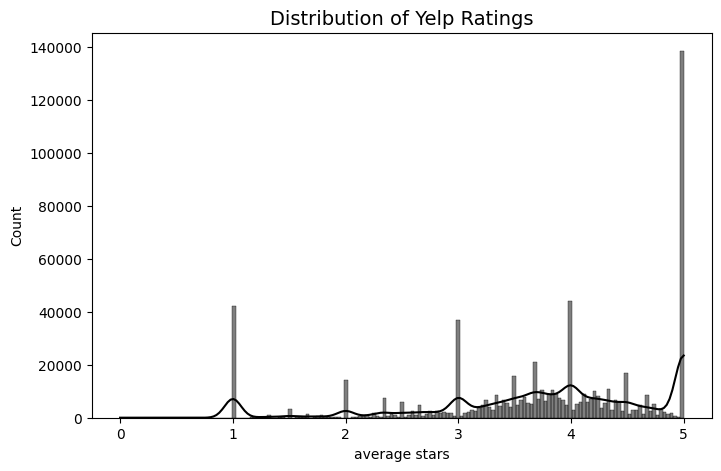

In [19]:
plt.figure(figsize = (8, 5))
sns.histplot(users.average_stars, color = 'black',kde=True)
plt.title('Distribution of Yelp Ratings', fontsize = 14)
plt.xlabel('average stars')
#plt.savefig('ratings-dist.png', dpi = 800)
plt.show()

Star distribution of yelp ratings for users with only one review.

In [20]:
onereview = users[users.review_count == 1]

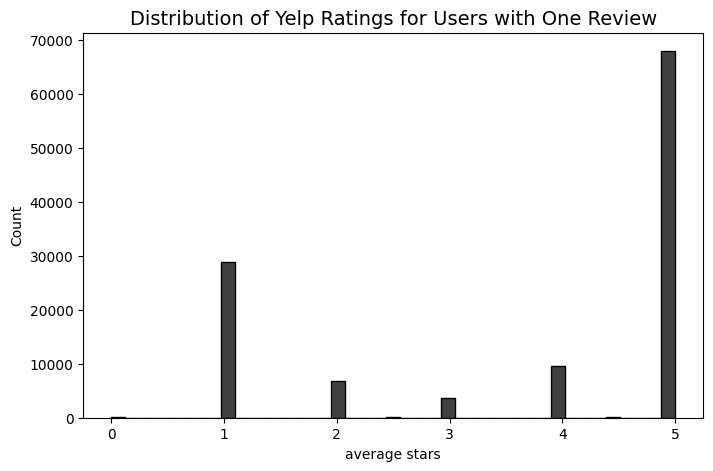

In [21]:
plt.figure(figsize = (8, 5))
sns.histplot(onereview.average_stars, color = 'black')
plt.title('Distribution of Yelp Ratings for Users with One Review', fontsize = 14)
plt.xlabel('average stars')
#plt.savefig('ratings-dist.png', dpi = 800)
plt.show()

Investigate pair-wise correlation between major user metadata features using normalized data.

In [22]:
users

,yelping_since,votes,review_count,name,user_id,friends,fans,average_stars,type,compliments,...,avg_num_para,freq_mentions_price,avg_num_allcaps,avg_num_excl,num_chars,ari_score,avg_chars_per_word,num_elite_words,num_ne_words,net_elite_wrds
0,2004-10-01,695,108,Russel,18kPq7GPye-YQ3LyKyAZPw,"[rpOyqD_893cqmDAtJLbdog, 4U9kSBLuBDU391x6bxU-Y...",69,4.14,user,"{'profile': 8, 'cute': 15, 'funny': 11, 'plain...",...,1.000000,0.000000,0.000000,0.000000,62.000000,1.761905,4.428571,3.00,3.000000,0.000000
1,2004-10-01,35732,1292,Jeremy,rpOyqD_893cqmDAtJLbdog,"[18kPq7GPye-YQ3LyKyAZPw, 4U9kSBLuBDU391x6bxU-Y...",1345,3.67,user,"{'profile': 117, 'cute': 204, 'funny': 594, 'p...",...,1.964286,0.214286,0.142857,0.285714,432.964286,6.245173,4.365314,12.25,12.107143,0.142857
2,2004-10-01,2728,395,Michael,4U9kSBLuBDU391x6bxU-YA,"[18kPq7GPye-YQ3LyKyAZPw, rpOyqD_893cqmDAtJLbdo...",105,3.68,user,"{'profile': 9, 'cute': 22, 'funny': 96, 'plain...",...,4.250000,0.250000,0.750000,1.250000,489.750000,4.294305,4.134757,10.50,10.750000,-0.250000
3,2004-10-01,17,11,Ken,fHtTaujcyKvXglE33Z5yIw,"[18kPq7GPye-YQ3LyKyAZPw, rpOyqD_893cqmDAtJLbdo...",2,4.64,user,{'cute': 2},...,1.000000,0.000000,0.500000,0.500000,61.500000,4.366548,4.813492,1.50,1.000000,0.500000
4,2004-10-01,66,66,Katherine,SIBCL7HBkrP4llolm4SC2A,"[rpOyqD_893cqmDAtJLbdog, HDQixQ-WZEV0LVPJlIGQe...",5,3.80,user,"{'cute': 2, 'plain': 2, 'writer': 2, 'note': 1...",...,1.000000,0.000000,0.000000,0.000000,27.000000,2.765000,4.500000,1.00,1.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
686551,2015-09-01,2,4,Nick,edetLs2KhHLCiJilqjdeUQ,[],0,4.00,user,{},...,1.000000,0.000000,0.000000,0.000000,306.000000,4.396621,4.191781,11.00,12.000000,-1.000000
686552,2015-09-01,11,51,Queenie,q0tofG0bWFv8ou0ea4aAiA,[],0,3.36,user,{},...,1.000000,0.000000,0.000000,0.000000,280.000000,4.817564,4.307692,9.50,10.500000,-1.000000
686553,2015-12-01,1,3,Nancy,JV-CHnvX6qrQzRQOL2yxCA,[],0,5.00,user,{},...,1.000000,0.000000,0.000000,1.000000,232.000000,5.610497,5.043478,12.00,12.000000,0.000000
686554,2016-02-01,3,1,MAureen,uRM8uxxbhum_Bedx1c1frw,[],0,5.00,user,{},...,1.000000,0.000000,0.000000,5.000000,622.000000,4.815943,4.289655,9.00,13.000000,-4.000000


In [97]:
whole_imbalanced_sample = users.drop(columns=['yelping_since','friends','name','type','compliments','elite','user_id','is_elite']).fillna(0)
whole_imbalanced_sample

,votes,review_count,fans,average_stars,comps,elite_yrs,friends_num,elite_friends_num,pct_friends_elite,yrs_yelping,...,avg_num_para,freq_mentions_price,avg_num_allcaps,avg_num_excl,num_chars,ari_score,avg_chars_per_word,num_elite_words,num_ne_words,net_elite_wrds
0,695,108,69,4.14,229,2,200,180,0.900000,19,...,1.000000,0.000000,0.000000,0.000000,62.000000,1.761905,4.428571,3.00,3.000000,0.000000
1,35732,1292,1345,3.67,6164,12,1939,1705,0.879319,19,...,1.964286,0.214286,0.142857,0.285714,432.964286,6.245173,4.365314,12.25,12.107143,0.142857
2,2728,395,105,3.68,598,11,422,272,0.644550,19,...,4.250000,0.250000,0.750000,1.250000,489.750000,4.294305,4.134757,10.50,10.750000,-0.250000
3,17,11,2,4.64,2,0,4,3,0.750000,19,...,1.000000,0.000000,0.500000,0.500000,61.500000,4.366548,4.813492,1.50,1.000000,0.500000
4,66,66,5,3.80,10,1,4,1,0.250000,19,...,1.000000,0.000000,0.000000,0.000000,27.000000,2.765000,4.500000,1.00,1.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
686551,2,4,0,4.00,0,0,0,0,0.000000,8,...,1.000000,0.000000,0.000000,0.000000,306.000000,4.396621,4.191781,11.00,12.000000,-1.000000
686552,11,51,0,3.36,0,0,0,0,0.000000,8,...,1.000000,0.000000,0.000000,0.000000,280.000000,4.817564,4.307692,9.50,10.500000,-1.000000
686553,1,3,0,5.00,0,0,0,0,0.000000,8,...,1.000000,0.000000,0.000000,1.000000,232.000000,5.610497,5.043478,12.00,12.000000,0.000000
686554,3,1,0,5.00,0,0,0,0,0.000000,7,...,1.000000,0.000000,0.000000,5.000000,622.000000,4.815943,4.289655,9.00,13.000000,-4.000000


In [72]:
analysis = users.drop(columns=['yelping_since','friends','name','type','compliments','elite']).fillna(0)
analysis

,votes,review_count,user_id,fans,average_stars,is_elite,comps,elite_yrs,friends_num,elite_friends_num,...,avg_num_para,freq_mentions_price,avg_num_allcaps,avg_num_excl,num_chars,ari_score,avg_chars_per_word,num_elite_words,num_ne_words,net_elite_wrds
0,695,108,18kPq7GPye-YQ3LyKyAZPw,69,4.14,1,229,2,200,180,...,1.000000,0.000000,0.000000,0.000000,62.000000,1.761905,4.428571,3.00,3.000000,0.000000
1,35732,1292,rpOyqD_893cqmDAtJLbdog,1345,3.67,1,6164,12,1939,1705,...,1.964286,0.214286,0.142857,0.285714,432.964286,6.245173,4.365314,12.25,12.107143,0.142857
2,2728,395,4U9kSBLuBDU391x6bxU-YA,105,3.68,1,598,11,422,272,...,4.250000,0.250000,0.750000,1.250000,489.750000,4.294305,4.134757,10.50,10.750000,-0.250000
3,17,11,fHtTaujcyKvXglE33Z5yIw,2,4.64,0,2,0,4,3,...,1.000000,0.000000,0.500000,0.500000,61.500000,4.366548,4.813492,1.50,1.000000,0.500000
4,66,66,SIBCL7HBkrP4llolm4SC2A,5,3.80,1,10,1,4,1,...,1.000000,0.000000,0.000000,0.000000,27.000000,2.765000,4.500000,1.00,1.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
686551,2,4,edetLs2KhHLCiJilqjdeUQ,0,4.00,0,0,0,0,0,...,1.000000,0.000000,0.000000,0.000000,306.000000,4.396621,4.191781,11.00,12.000000,-1.000000
686552,11,51,q0tofG0bWFv8ou0ea4aAiA,0,3.36,0,0,0,0,0,...,1.000000,0.000000,0.000000,0.000000,280.000000,4.817564,4.307692,9.50,10.500000,-1.000000
686553,1,3,JV-CHnvX6qrQzRQOL2yxCA,0,5.00,0,0,0,0,0,...,1.000000,0.000000,0.000000,1.000000,232.000000,5.610497,5.043478,12.00,12.000000,0.000000
686554,3,1,uRM8uxxbhum_Bedx1c1frw,0,5.00,0,0,0,0,0,...,1.000000,0.000000,0.000000,5.000000,622.000000,4.815943,4.289655,9.00,13.000000,-4.000000


In [234]:
def shuffle_balanced_sample(analysis):
    non_elite_set = analysis[(analysis['is_elite'] == 0)]
    elite_set = analysis[(analysis['is_elite'] == 1)]
    non_elite_set.sample(n=(len(elite_set))).set_index('user_id')
    temp = non_elite_set.sample(n=(len(elite_set)))
    row_balanced_sample = pd.concat([elite_set,temp], axis = 0)
    y = row_balanced_sample['is_elite']
    balanced_sample = row_balanced_sample.reset_index().drop(columns=['user_id','is_elite','index','elite_yrs'])
    return balanced_sample, y
#example
x, y = shuffle_balanced_sample(analysis)

In [235]:
def normalize_data(analysis):
    for i in analysis.columns:
            mean = analysis[i].mean()
            var = analysis[i].var()
            analysis[i] = analysis[i].apply(lambda x: (x - mean)/(var ** 0.5))
    return analysis

In [103]:
#example
#normalize_data(x)

,votes,review_count,fans,average_stars,comps,elite_yrs,friends_num,elite_friends_num,pct_friends_elite,yrs_yelping,...,avg_num_para,freq_mentions_price,avg_num_allcaps,avg_num_excl,num_chars,ari_score,avg_chars_per_word,num_elite_words,num_ne_words,net_elite_wrds
0,0.001705,-0.081541,1.773660,0.438891,0.081513,0.212218,1.628578,1.947497,1.313928,2.848067,...,-0.701460,-0.566437,-0.383877,-0.666832,-1.155751,-0.545120,0.085100,-1.219487,-1.229012,0.006942
1,11.661418,5.371280,39.267566,-0.137139,5.904762,5.016206,18.381500,20.766530,1.259837,2.848067,...,-0.177133,0.231630,-0.309022,-0.543616,-0.242208,0.099270,0.039080,-0.155187,-0.173686,0.143798
2,0.678253,1.240215,2.831482,-0.124883,0.443565,4.535807,3.767249,3.082809,0.645794,2.848067,...,1.065715,0.364641,0.009111,-0.127759,-0.102366,-0.181132,-0.128650,-0.356541,-0.330950,-0.232557
3,-0.207615,-0.274969,-0.106912,0.022188,-0.133363,-0.268181,-0.259618,-0.261425,-0.386156,2.848067,...,-0.701460,-0.566437,-0.383877,-0.666832,-1.241943,-0.400943,0.137064,-1.449606,-1.460770,0.006942
4,15.982603,6.937125,23.958534,0.696266,16.940972,5.016206,11.368201,11.696373,1.054968,2.848067,...,-0.701460,-0.566437,0.140106,-0.666832,-0.461293,0.375250,0.627940,-0.816779,-0.881375,0.485940
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71587,-0.228581,-0.546689,-0.224448,0.794314,-0.143175,-0.748580,-0.249985,-0.261425,-0.516932,-0.293357,...,-0.701460,-0.566437,-0.121885,-0.127759,-0.614591,0.022109,-0.159689,-0.471600,-0.533738,0.485940
71588,-0.228581,-0.565111,-0.253832,-0.958288,-0.143175,-0.748580,-0.134381,-0.261425,-0.886181,-1.471390,...,-0.429587,-0.566437,-0.383877,-0.451203,-0.095594,-0.210391,-0.156936,-0.126422,-0.012283,-0.951054
71589,-0.206950,-0.519057,-0.224448,-1.142127,-0.141212,-0.748580,-0.211450,-0.273766,-1.040035,0.884677,...,-0.157714,-0.566437,0.402098,-0.666832,-0.367714,-0.096234,-0.065060,-0.299011,-0.301980,0.006942
71590,-0.229246,-0.574322,-0.253832,-3.409479,-0.143175,-0.748580,-0.298153,-0.273766,-1.040035,-1.864068,...,-0.701460,-0.566437,-0.383877,-0.235574,-1.062172,-0.384184,0.026357,-1.219487,-1.344891,0.964938


In [26]:
from sklearn.decomposition import PCA 
from sklearn.preprocessing import StandardScaler

# 保留数据的前95%的主成分
pca = PCA(n_components=0.95)
pca.fit(analysis)
# 将数据变换到前两个主成分的方向上
X_pca = pca.transform(analysis)
print("Original shape: {}".format(str(analysis.shape)))     # Original shape: (569, 30)
print("Reduced shape: {}".format(str(X_pca.shape)))         # Reduced shape: (569, 2)

Original shape: (686556, 26)
Reduced shape: (686556, 17)


In [236]:
def get_PCA_data(analysis):
    pca = PCA(n_components=0.95)
    pca.fit(analysis)
    X_pca = pca.transform(analysis)
    return pca, X_pca

In [237]:
pca, X_pca = get_PCA_data(normalize_data(x))
X_pca

array([[-0.0781803 ,  3.99290075, -0.62149494, ..., -1.39116081,
         1.08886522, -0.60790848],
       [23.67136563, 31.60122389,  0.04187244, ...,  0.85201289,
         5.60460168,  0.58130463],
       [ 3.50204749,  3.86511675, -0.33964224, ..., -1.30864402,
         1.62143505,  0.69557219],
       ...,
       [-2.29459626,  0.35661119,  0.63854057, ...,  0.25053065,
        -0.2788202 ,  0.43356504],
       [-1.76302901,  0.19922346,  0.30163728, ..., -0.07481779,
         0.78212853, -0.06483375],
       [-0.24699249, -0.8532865 ,  0.31483646, ...,  0.21465625,
         1.38200662,  0.25347133]])

In [238]:
pca.components_.shape

(15, 25)

<Figure size 1200x600 with 0 Axes>

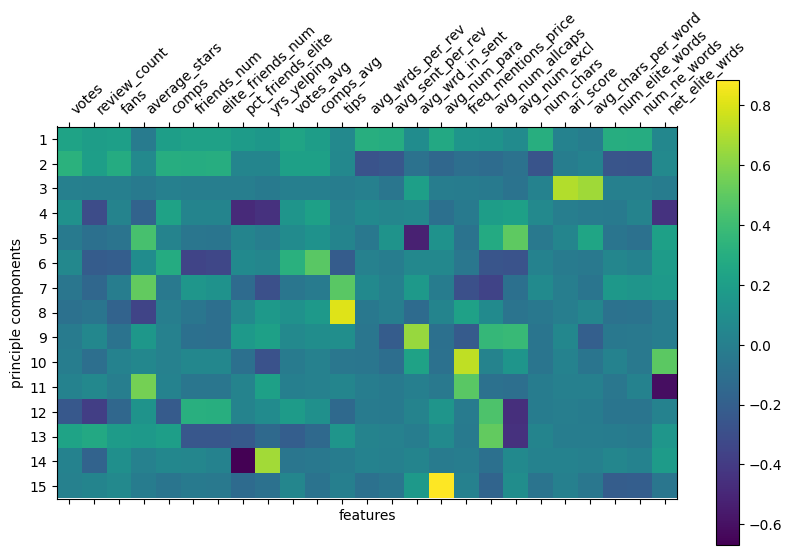

In [239]:
plt.figure(figsize=(12, 6))
plt.matshow(pca.components_, cmap='viridis')
plt.yticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14],[ '1','2','3','4','5','6','7','8','9','10','11','12','13','14','15'])
plt.colorbar()
plt.xticks(range(len(x.columns)),
           x.columns, rotation=43, ha='left')
plt.xlabel("features")
plt.ylabel("principle components")
plt.savefig('yelp-principle_component.png', dpi = 500)

[27.91611932 16.25825638  7.91568745  6.35225781  5.08758532  4.62031738
  4.13831688  3.82785823  3.5754393   3.31001447  3.13717182  2.6873576
  2.60471173  2.1288102   1.67653039]


Text(0, 0.5, 'Explained variance (%)')

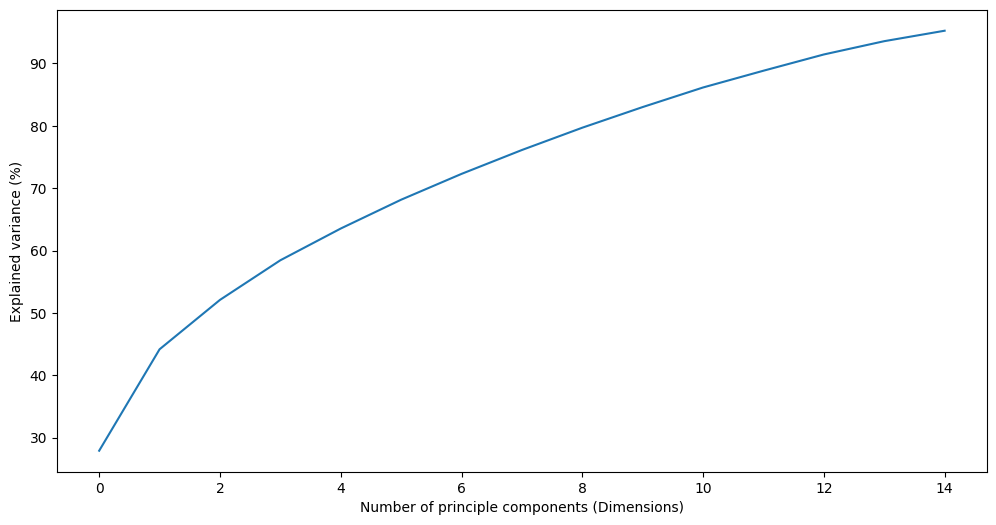

In [240]:
print(pca.explained_variance_ratio_ * 100)
plt.plot(np.cumsum(pca.explained_variance_ratio_ * 100))
plt.xlabel("Number of principle components (Dimensions)")
plt.ylabel("Explained variance (%)")

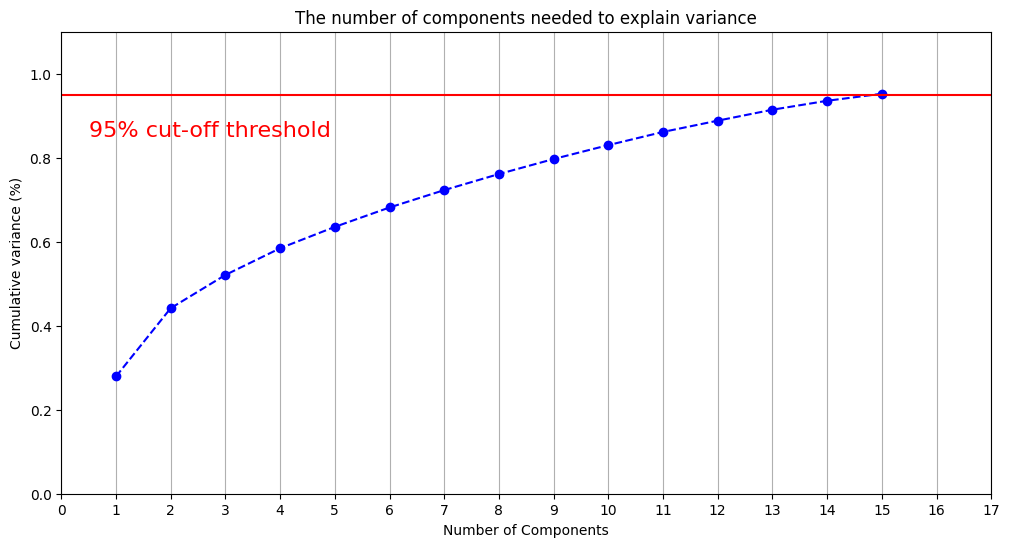

In [243]:
plt.rcParams["figure.figsize"] = (12,6)

fig, ax = plt.subplots()
xi = np.arange(1, 16, step=1)
y = np.cumsum(pca.explained_variance_ratio_)

plt.ylim(0.0,1.1)
plt.plot(xi, y, marker='o', linestyle='--', color='b')

plt.xlabel('Number of Components')
plt.xticks(np.arange(0, 18, step=1)) #change from 0-based array index to 1-based human-readable label
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain variance')

plt.axhline(y=0.95, color='r', linestyle='-')
plt.text(0.5, 0.85, '95% cut-off threshold', color = 'red', fontsize=16)

ax.grid(axis='x')
plt.show()

## 4. Explore potential classification models

Test the following models on exhaustive list of features:\
linear classifiers with stochastic gradient descent optimization (logistic regression)\
random forest classifier\
Define functions to get scores for different models and feature combinations.

### Get Logstic regression perfromance (with pca data)

In [330]:
def plot_roc(m, xtest, ytest):
    """Plot ROC curve and calcuate AUC score for model."""
    pred = m.predict_proba(xtest)
    tpr, fpr, thresh = roc_curve(ytest, pred[:, 1])
    auc_score = auc(tpr, fpr)
    plt.plot(tpr, fpr,"r",linewidth = 2)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title('%s ROC' % str(m).split('(')[0])
    plt.xlabel('false positive rate')
    plt.ylabel('true positive rate')
    plt.xlim([-0.1, 1.1])
    plt.ylim([-0.1, 1.1])
    plt.text(0.2,0.8,"AUC = "+str(round(auc_score,4)))
    plt.savefig('yelp-rf_roc.pdf', dpi = 500)
    plt.show()

In [331]:
def plot_roc_lr(m, xtest, ytest):
    """Plot ROC curve and calcuate AUC score for model."""
    pred = m.predict_proba(xtest)
    tpr, fpr, thresh = roc_curve(ytest, pred[:, 1])
    auc_score = auc(tpr, fpr)
    plt.plot(tpr, fpr,"r",linewidth = 2)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title('%s ROC' % str(m).split('(')[0])
    plt.xlabel('false positive rate')
    plt.ylabel('true positive rate')
    plt.xlim([-0.1, 1.1])
    plt.ylim([-0.1, 1.1])
    plt.text(0.2,0.8,"AUC = "+str(round(auc_score,4)))
    plt.savefig('yelp-lr_roc.pdf', dpi = 500)
    plt.show()

In [317]:
def eval_logistic_model(df):
    acc_scores = []
    p_scores = []
    r_scores = []
    f1_scores = []
    auc_scores = []
    rmse_values = []
    for i in range(5):
        balanced_data,y = shuffle_balanced_sample(df)
        normalized_data = normalize_data(balanced_data)
        pca , X_pca = get_PCA_data(normalized_data)
        xtrain, xtest, ytrain, ytest = train_test_split(
            X_pca, y, test_size = .25,shuffle=True)
        rcf = LogisticRegression()
        m = rcf.fit(xtrain,ytrain)
        predic = m.predict(xtest)
        conf_mat = confusion_matrix(ytest, predic)
        print(conf_mat)
        #
        acc_score = (conf_mat[1,1] + conf_mat[0,0]) /  len(y) * 4
        p_score = conf_mat[1,1] / (conf_mat[1,1] + conf_mat[0,1])
        r_score = conf_mat[1,1] / (conf_mat[1,1] + conf_mat[1,0])
        f1_score = 2 * p_score * r_score / (p_score + r_score)
        rmse_value = mean_squared_error(ytrain,m.predict(xtrain),squared=False)
        acc_scores.append(acc_score)
        p_scores.append(p_score)
        r_scores.append(r_score)
        f1_scores.append(f1_score)
        rmse_values.append(rmse_value)
    plot_roc_lr(m,xtest,ytest)
    return np.array(acc_scores).mean(),np.array(p_scores).mean(),np.array(r_scores).mean(),np.array(f1_scores).mean(),np.array(rmse_values).mean()

[[8503  401]
 [ 504 8490]]
[[8470  430]
 [ 465 8533]]
[[8505  440]
 [ 512 8441]]
[[8520  420]
 [ 457 8501]]
[[8556  447]
 [ 471 8424]]


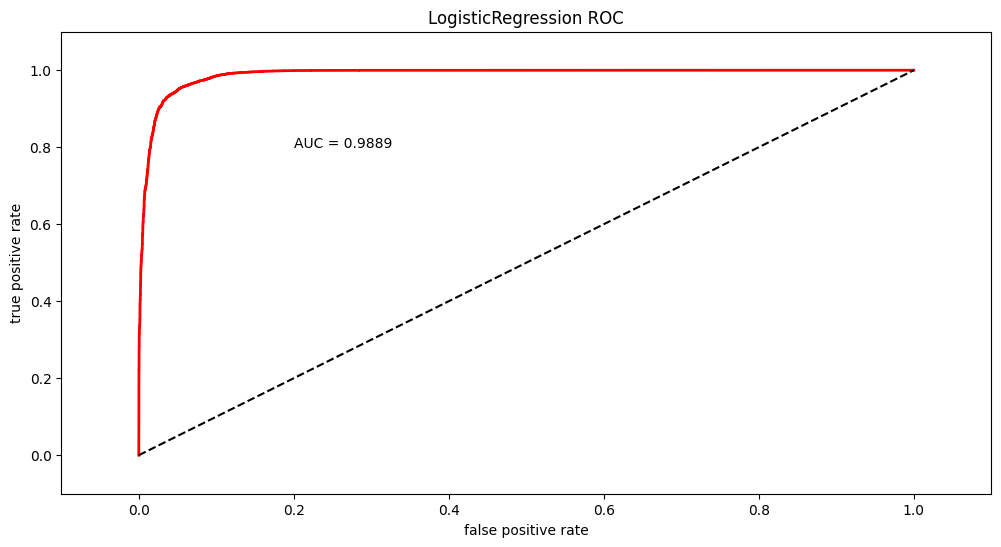

(0.9491898536149289,
 0.9519820803162629,
 0.9462260016564954,
 0.94909277501867,
 0.22527163726581226)

In [318]:
eval_logistic_model(analysis)

### Get Logstic regression perfromance (without pca data)

In [332]:
def eval_logistic_model(df):
    acc_scores = []
    p_scores = []
    r_scores = []
    f1_scores = []
    auc_scores = []
    rmse_values = []
    for i in range(5):
        balanced_data,y = shuffle_balanced_sample(df)
        normalized_data = normalize_data(balanced_data)
        xtrain, xtest, ytrain, ytest = train_test_split(
            normalized_data.to_numpy(), y, test_size = .25,shuffle=True)
        rcf = LogisticRegression()
        m = rcf.fit(xtrain,ytrain)
        predic = m.predict(xtest)
        conf_mat = confusion_matrix(ytest, predic)
        print(conf_mat)
        #
        acc_score = (conf_mat[1,1] + conf_mat[0,0]) /  len(y) * 4
        p_score = conf_mat[1,1] / (conf_mat[1,1] + conf_mat[0,1])
        r_score = conf_mat[1,1] / (conf_mat[1,1] + conf_mat[1,0])
        f1_score = 2 * p_score * r_score / (p_score + r_score)
        rmse_value = mean_squared_error(ytrain,m.predict(xtrain),squared=False)
        acc_scores.append(acc_score)
        p_scores.append(p_score)
        r_scores.append(r_score)
        f1_scores.append(f1_score)
        rmse_values.append(rmse_value)
    plot_roc_lr(m,xtest,ytest)
    return np.array(acc_scores).mean(),np.array(p_scores).mean(),np.array(r_scores).mean(),np.array(f1_scores).mean(),np.array(rmse_values).mean()

C:\Users\47965\miniconda3\envs\pytorch\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[[8492  440]
 [ 482 8484]]


C:\Users\47965\miniconda3\envs\pytorch\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[[8453  433]
 [ 416 8596]]


C:\Users\47965\miniconda3\envs\pytorch\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[[8448  427]
 [ 447 8576]]


C:\Users\47965\miniconda3\envs\pytorch\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[[8687  404]
 [ 445 8362]]


C:\Users\47965\miniconda3\envs\pytorch\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[[8438  470]
 [ 449 8541]]


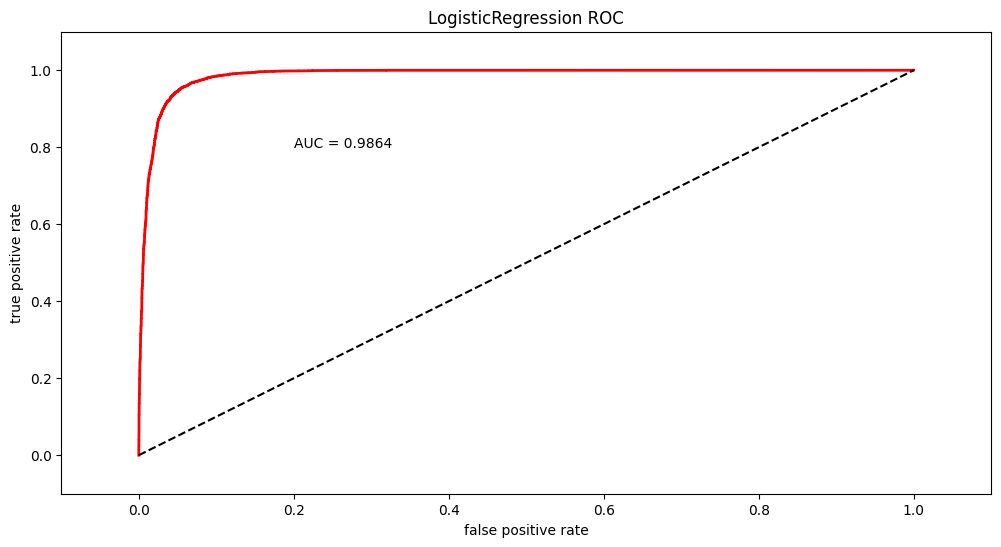

(0.9506872276231982,
 0.9514127817163803,
 0.9500136491103023,
 0.9507104720062507,
 0.2237301732527001)

In [333]:
eval_logistic_model(analysis)

### Random Forest performance (with pca data)

In [308]:
def evaluate_random_forest_model(df):
    acc_scores = []
    p_scores = []
    r_scores = []
    f1_scores = []
    auc_scores = []
    rmse_values = []
    for i in range(5):
        balanced_data,y = shuffle_balanced_sample(df)
        normalized_data = normalize_data(balanced_data)
        pca , X_pca = get_PCA_data(normalized_data)
        xtrain, xtest, ytrain, ytest = train_test_split(
            X_pca, y, test_size = .25,shuffle=True)
        rcf = RandomForestClassifier(n_estimators=100, random_state=90)
        m = rcf.fit(xtrain,ytrain)
        predic = m.predict(xtest)
        conf_mat = confusion_matrix(ytest, predic)
        print(conf_mat)
        #
        acc_score = (conf_mat[1,1] + conf_mat[0,0]) /  len(y) * 4
        p_score = conf_mat[1,1] / (conf_mat[1,1] + conf_mat[0,1])
        r_score = conf_mat[1,1] / (conf_mat[1,1] + conf_mat[1,0])
        f1_score = 2 * p_score * r_score / (p_score + r_score)
        rmse_value = mean_squared_error(ytest,predic,squared=False)
        acc_scores.append(acc_score)
        p_scores.append(p_score)
        r_scores.append(r_score)
        f1_scores.append(f1_score)
        rmse_values.append(rmse_value)
    plot_roc(m,xtest,ytest)
    return  np.array(acc_scores).mean(),np.array(p_scores).mean(),np.array(r_scores).mean(),np.array(f1_scores).mean(),np.array(rmse_values).mean()

[[8205  750]
 [ 430 8513]]
[[8125  723]
 [ 461 8589]]
[[8190  777]
 [ 466 8465]]
[[8193  756]
 [ 464 8485]]
[[8167  774]
 [ 475 8482]]


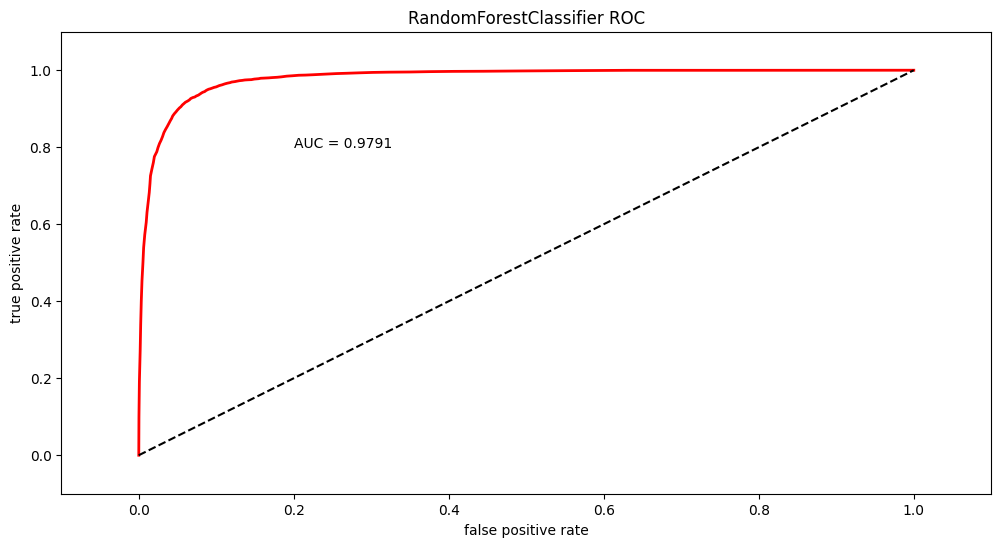

(0.932104145714605,
 0.9183774967866775,
 0.9487840298745681,
 0.9333319655045796,
 0.26054998988304623)

In [309]:
evaluate_random_forest_model(analysis)

### Random Forest performance (without pca data)

In [334]:
def evaluate_random_forest_model_nopca(df):
    acc_scores = []
    p_scores = []
    r_scores = []
    f1_scores = []
    auc_scores = []
    rmse_values = []
    for i in range(5):
        balanced_data,y = shuffle_balanced_sample(df)
        xtrain, xtest, ytrain, ytest = train_test_split(
            balanced_data.to_numpy(), y, test_size = .25,shuffle=True)
        rcf = RandomForestClassifier(n_estimators=100, random_state=90)
        m = rcf.fit(xtrain,ytrain)
        predic = m.predict(xtest)
        conf_mat = confusion_matrix(ytest, predic)
        print(conf_mat)
        #
        acc_score = (conf_mat[1,1] + conf_mat[0,0]) /  len(y) * 4
        p_score = conf_mat[1,1] / (conf_mat[1,1] + conf_mat[0,1])
        r_score = conf_mat[1,1] / (conf_mat[1,1] + conf_mat[1,0])
        f1_score = 2 * p_score * r_score / (p_score + r_score)
        rmse_value = mean_squared_error(ytest,predic,squared=False)
        acc_scores.append(acc_score)
        p_scores.append(p_score)
        r_scores.append(r_score)
        f1_scores.append(f1_score)
        rmse_values.append(rmse_value)
    
    plot_roc(m,xtest,ytest)
    importance = m.feature_importances_

    for i,v in zip(balanced_data.columns,importance):
        print(i) 
        print('Score: %.5f' % v)
    return  np.array(acc_scores).mean(),np.array(p_scores).mean(),np.array(r_scores).mean(),np.array(f1_scores).mean(),np.array(rmse_values).mean()

[[8561  447]
 [ 222 8668]]
[[8506  456]
 [ 211 8725]]
[[8451  481]
 [ 198 8768]]
[[8426  478]
 [ 202 8792]]
[[8527  462]
 [ 234 8675]]


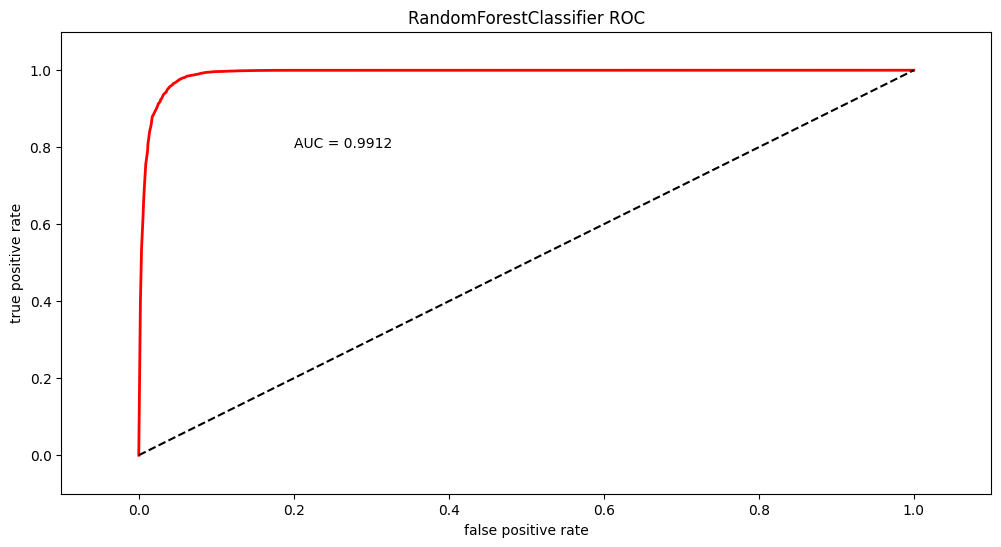

votes
Score: 0.17825
review_count
Score: 0.23578
fans
Score: 0.07588
average_stars
Score: 0.01265
comps
Score: 0.21577
friends_num
Score: 0.03411
elite_friends_num
Score: 0.07932
pct_friends_elite
Score: 0.03762
yrs_yelping
Score: 0.01151
votes_avg
Score: 0.01340
comps_avg
Score: 0.02366
tips
Score: 0.00245
avg_wrds_per_rev
Score: 0.00690
avg_sent_per_rev
Score: 0.00526
avg_wrd_in_sent
Score: 0.00609
avg_num_para
Score: 0.01379
freq_mentions_price
Score: 0.00267
avg_num_allcaps
Score: 0.00397
avg_num_excl
Score: 0.00447
num_chars
Score: 0.00562
ari_score
Score: 0.00618
avg_chars_per_word
Score: 0.00624
num_elite_words
Score: 0.00808
num_ne_words
Score: 0.00497
net_elite_wrds
Score: 0.00537


(0.9621074980444743,
 0.9494317427658446,
 0.9761214698317694,
 0.9625901237370226,
 0.19465437502314717)

In [335]:
evaluate_random_forest_model_nopca(analysis)

[[8401  474]
 [ 182 8841]]
[[8439  471]
 [ 194 8794]]
[[8440  485]
 [ 203 8770]]
[[8445  435]
 [ 209 8809]]
[[8385  445]
 [ 213 8855]]


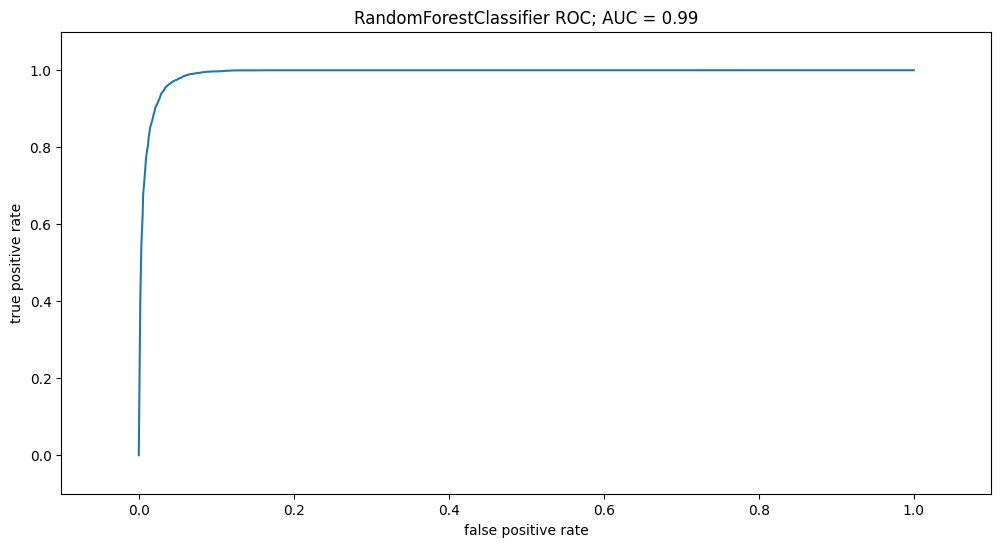

votes
Score: 0.17053
review_count
Score: 0.23360
fans
Score: 0.08191
average_stars
Score: 0.01284
comps
Score: 0.21006
friends_num
Score: 0.03399
elite_friends_num
Score: 0.08810
pct_friends_elite
Score: 0.03749
yrs_yelping
Score: 0.01152
votes_avg
Score: 0.01284
comps_avg
Score: 0.02361
tips
Score: 0.00227
avg_wrds_per_rev
Score: 0.00698
avg_sent_per_rev
Score: 0.00522
avg_wrd_in_sent
Score: 0.00629
avg_num_para
Score: 0.01505
freq_mentions_price
Score: 0.00250
avg_num_allcaps
Score: 0.00413
avg_num_excl
Score: 0.00418
num_chars
Score: 0.00581
ari_score
Score: 0.00603
avg_chars_per_word
Score: 0.00628
num_elite_words
Score: 0.00796
num_ne_words
Score: 0.00491
net_elite_wrds
Score: 0.00590


(0.9630014526762768,
 0.9501933462486786,
 0.9777913002619307,
 0.9637926272096978)

In [264]:
evaluate_random_forest_model_nopca(analysis)

In [342]:
#plot roc for lr and rf in one graph
def plot_roc_both(df):
    balanced_data,y = shuffle_balanced_sample(df)
    xtrain, xtest, ytrain, ytest = train_test_split(
            balanced_data.to_numpy(), y, test_size = .25,shuffle=True)
    rcf = RandomForestClassifier(n_estimators=100, random_state=90)
    m = rcf.fit(xtrain,ytrain)
    lr = LogisticRegression()
    n = lr.fit(xtrain,ytrain)

    """Plot ROC curve and calcuate AUC score for both models."""
    pred_rcf = m.predict_proba(xtest)
    tpr_rcf, fpr_rcf, thresh_rcf = roc_curve(ytest, pred_rcf[:, 1])
    auc_score_rcf = auc(tpr_rcf, fpr_rcf)
    plt.plot(tpr_rcf, fpr_rcf,"r",linewidth = 2,label='Random Forest Classifier')
    pred_lr = n.predict_proba(xtest)
    tpr_lr, fpr_lr, thresh_lr = roc_curve(ytest, pred_lr[:, 1])
    auc_score_lr = auc(tpr_lr, fpr_lr)
    plt.plot(tpr_lr, fpr_lr,"b",linewidth = 2,label='Random Forest Classifier')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title('ROC of both models' )
    plt.xlabel('false positive rate')
    plt.ylabel('true positive rate')
    plt.xlim([-0.1, 1.1])
    plt.ylim([-0.1, 1.1])
    plt.legend()
    plt.text(0.2,0.7,"AUC of logistic regression model = "+str(round(auc_score_lr,4)))
    plt.text(0.2,0.8,"AUC of random forest model = "+str(round(auc_score_rcf,4)))
    plt.savefig('yelp_roc.pdf', dpi = 500)
    plt.show()

C:\Users\47965\miniconda3\envs\pytorch\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


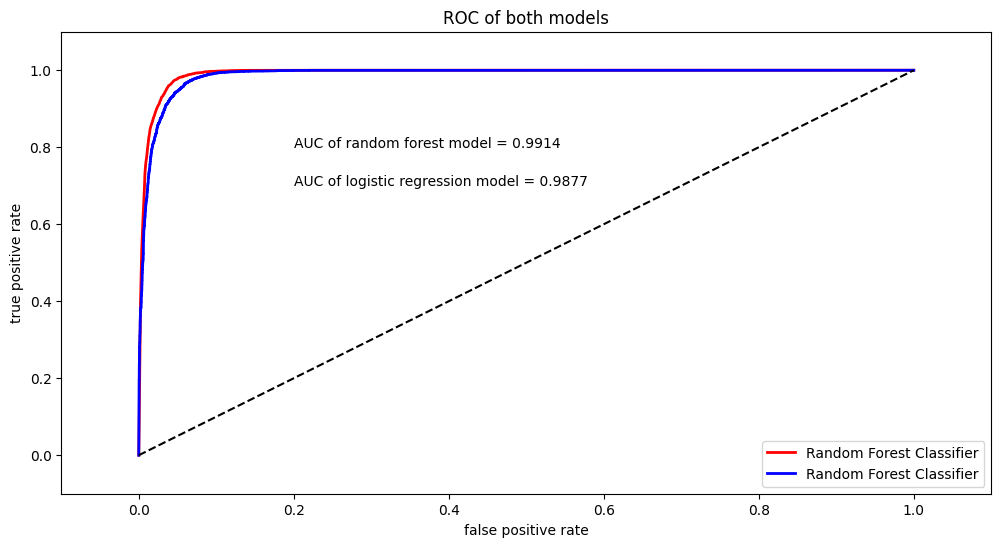

In [343]:
plot_roc_both(analysis)

### Sklearn Random forest feature importance graph

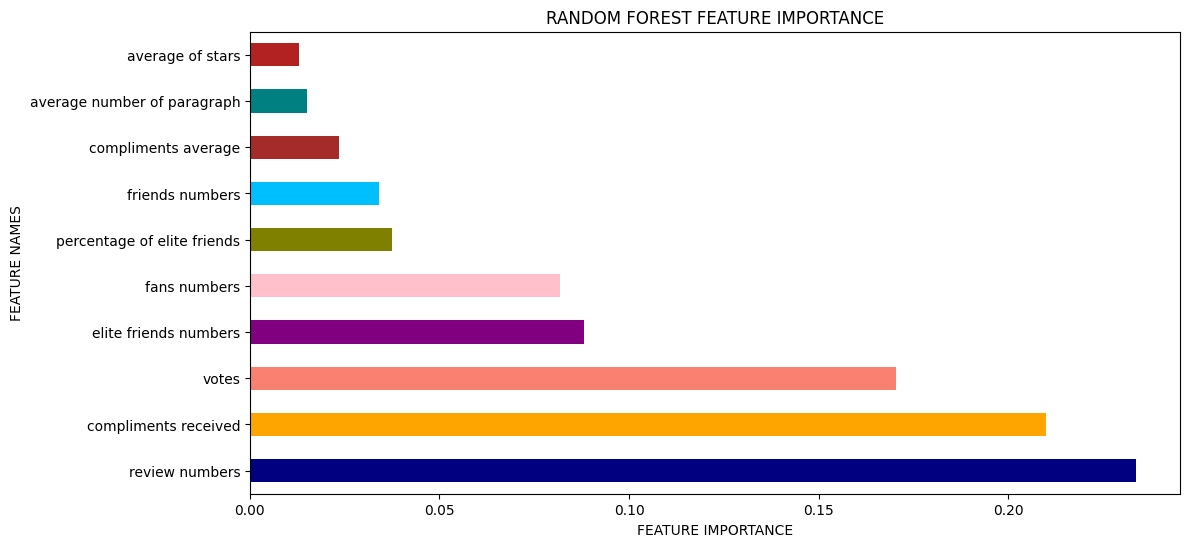

In [291]:
importance = pd.Series([0.23360,0.21006,0.17053,0.08810,0.08191,0.03749,0.03399,0.02361,0.01505,0.01284],
                       index=['review numbers','compliments received','votes','elite friends numbers','fans numbers','percentage of elite friends','friends numbers','compliments average','average number of paragraph','average of stars'])

importance.plot(kind='barh',color=['navy','orange','salmon','purple','pink','olive','deepskyblue','brown','teal','firebrick'])
plt.title('RANDOM FOREST FEATURE IMPORTANCE')
plt.ylabel('FEATURE NAMES')
plt.xlabel('FEATURE IMPORTANCE')
plt.savefig('yelp-feature_importances.png', dpi = 500,bbox_inches = 'tight')
plt.show()

### Percentage of elite users

In [476]:
users.is_elite.sum()/len(users.is_elite)

0.052138499991260724

In [301]:
#didnot show good performance so leave it here
class LogisticRegression(nn.Module):
    def __init__(self):
        super(LogisticRegression,self).__init__()
        self.lr=nn.Linear(15,1)   #相当于通过线性变换y=x*T(A)+b可以得到对应的各个系数
        self.sm=nn.Sigmoid()   #相当于通过激活函数的变换

    def forward(self, x):
        x=self.lr(x)
        x=self.sm(x)
        return x


def eval_logistic_model(df):
    acc_scores = []
    p_scores = []
    r_scores = []
    f1_scores = []
    auc_scores = []
    rmse_values = []
    for i in range(5):
        balanced_data,y = shuffle_balanced_sample(df)
        normalized_data = normalize_data(balanced_data)
        pca , X_pca = get_PCA_data(normalized_data)
        xtrain, xtest, ytrain, ytest = train_test_split(
            X_pca, y, test_size = .25,shuffle=True)
        xTrainData = torch.from_numpy(xtrain)
        yTrainData = torch.from_numpy(np.array(ytrain.to_numpy()).T)
        xTestData = torch.from_numpy(xtest)
        yTestData = torch.from_numpy(np.array(ytest.to_numpy()).T)
        #create model and train the model
        model = LogisticRegression()
        criterion=nn.BCELoss()   #选用BCE损失函数,该损失函数是只用于2分类问题的损失函数
        optimizer=torch.optim.SGD(model.parameters(),lr=1e-3,momentum=0.9)  #采用随机梯度下降的方法
        
        for epoch in range(10000):

            x_data=Variable(xTrainData.to(torch.float32))
            y_data=Variable(yTrainData.to(torch.float32))
            y_data = y_data.unsqueeze(1)
            out=model(x_data)  #根据逻辑回归模型拟合出的y值

            loss=criterion(out,y_data)  #计算损失函数
            print_loss=loss.data.item()  #得出损失函数值
            mask=out.ge(0.5).float()  #以0.5为阈值进行分类
            correct=(mask==y_data).sum()  #计算正确预测的样本个数
            acc=correct.item()/x_data.size(0)  #计算精度
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        rmse_value = mean_squared_error(ytrain,mask)
        #test the model    
        out = model(xTestData.to(torch.float32))
        mask=out.ge(0.5).float()
        yTestData_iter = data.DataLoader(np.array(ytest).reshape(ytest.shape[0],1), batch_size=256, shuffle=False)
        mask_iter = data.DataLoader(mask, batch_size=256, shuffle=False)
        #get acc
        total_true = torch.tensor(0)
        for i, ss in enumerate(zip(yTestData_iter,mask_iter)):
            total_true = total_true + (ss[0]==ss[1]).sum()
            # i表示第几个batch， data表示该batch对应的数据，包含data和对应的labels
        acc=total_true.item()/xTestData.size(0)
        acc_scores.append(acc)
        #get 
        conf_matrix_baseline = pd.DataFrame(confusion_matrix(np.array(ytest).reshape(ytest.shape[0],1), mask), 
                                            index = ['actual 0', 'actual 1'], columns = ['predicted 0', 'predicted 1'])
        print(conf_matrix_baseline)
        p_score = conf_matrix_baseline.iloc[1].iloc[1] / (conf_matrix_baseline.iloc[1].iloc[1] + conf_matrix_baseline.iloc[0].iloc[1])
        r_score = conf_matrix_baseline.iloc[1].iloc[1] / (conf_matrix_baseline.iloc[1].iloc[1] + conf_matrix_baseline.iloc[1].iloc[0])
        f1_score = 2 * p_score * r_score / (p_score + r_score)
        p_scores.append(p_score)
        r_scores.append(r_score)
        f1_scores.append(f1_score)
        rmse_values.append(rmse_value)
    plot_roc_lr(mask,ytest)
    return np.array(acc_scores).mean(),np.array(p_scores).mean(),np.array(r_scores).mean(),np.array(f1_scores).mean(),np.array(rmse_values).mean()

In [305]:
class LogisticRegression(nn.Module):
    def __init__(self):
        super(LogisticRegression,self).__init__()
        self.lr=nn.Linear(25,1)   #相当于通过线性变换y=x*T(A)+b可以得到对应的各个系数
        self.sm=nn.Sigmoid()   #相当于通过激活函数的变换

    def forward(self, x):
        x=self.lr(x)
        x=self.sm(x)
        return x


def eval_logistic_model_nopca(df):
    acc_scores = []
    p_scores = []
    r_scores = []
    f1_scores = []
    auc_scores = []
    rmse_values = []
    for i in range(5):
        balanced_data,y = shuffle_balanced_sample(df)
        normalized_data = normalize_data(balanced_data)
        xtrain, xtest, ytrain, ytest = train_test_split(
            normalized_data.to_numpy(), y, test_size = .25,shuffle=True)
        xTrainData = torch.from_numpy(xtrain)
        yTrainData = torch.from_numpy(np.array(ytrain.to_numpy()).T)
        xTestData = torch.from_numpy(xtest)
        yTestData = torch.from_numpy(np.array(ytest.to_numpy()).T)
        #create model and train the model
        model = LogisticRegression()
        criterion=nn.BCELoss()   #选用BCE损失函数,该损失函数是只用于2分类问题的损失函数
        optimizer=torch.optim.SGD(model.parameters(),lr=1e-3,momentum=0.9)  #采用随机梯度下降的方法
        
        for epoch in range(10000):
            
            x_data=Variable(xTrainData.to(torch.float32))
            y_data=Variable(yTrainData.to(torch.float32))
            y_data = y_data.unsqueeze(1)
            out=model(x_data)  #根据逻辑回归模型拟合出的y值

            loss=criterion(out,y_data)  #计算损失函数
            print_loss=loss.data.item()  #得出损失函数值
            mask=out.ge(0.5).float()  #以0.5为阈值进行分类
            correct=(mask==y_data).sum()  #计算正确预测的样本个数
            acc=correct.item()/x_data.size(0)  #计算精度
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        rmse_value = mean_squared_error(ytrain,mask)
        #test the model    
        out = model(xTestData.to(torch.float32))
        mask=out.ge(0.5).float()
        yTestData_iter = data.DataLoader(np.array(ytest).reshape(ytest.shape[0],1), batch_size=256, shuffle=False)
        mask_iter = data.DataLoader(mask, batch_size=256, shuffle=False)
        #get acc
        total_true = torch.tensor(0)
        for i, ss in enumerate(zip(yTestData_iter,mask_iter)):
            total_true = total_true + (ss[0]==ss[1]).sum()
            # i表示第几个batch， data表示该batch对应的数据，包含data和对应的labels
        acc=total_true.item()/xTestData.size(0)
        acc_scores.append(acc)
        #get 
        conf_matrix_baseline = pd.DataFrame(confusion_matrix(np.array(ytest).reshape(ytest.shape[0],1), mask), 
                                            index = ['actual 0', 'actual 1'], columns = ['predicted 0', 'predicted 1'])
        print(conf_matrix_baseline)
        p_score = conf_matrix_baseline.iloc[1].iloc[1] / (conf_matrix_baseline.iloc[1].iloc[1] + conf_matrix_baseline.iloc[0].iloc[1])
        r_score = conf_matrix_baseline.iloc[1].iloc[1] / (conf_matrix_baseline.iloc[1].iloc[1] + conf_matrix_baseline.iloc[1].iloc[0])
        f1_score = 2 * p_score * r_score / (p_score + r_score)
        p_scores.append(p_score)
        r_scores.append(r_score)
        f1_scores.append(f1_score)
        rmse_values.append(rmse_value)
    plot_roc_lr(mask,ytest)
    return np.array(acc_scores).mean(),np.array(p_scores).mean(),np.array(r_scores).mean(),np.array(f1_scores).mean(),np.array(rmse_values).mean()